In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GroupKFold
import numpy as np
from scipy.stats import wilcoxon
import pandas as pd
import typing as tp
from explanatory_analysis import SpDataCleaner
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

In [8]:
df_rf_params = pd.read_csv('reports/5_20.0/best_params_rf_5.0_20.0.csv')

df_rf_params.rename(columns={'Unnamed: 0': 'Model'}, inplace=True)

Index(['Model', 'n_estimators', 'min_samples_split', 'min_samples_leaf',
       'max_depth', 'criterion', 'bootstrap'],
      dtype='object')

In [9]:
spdc = SpDataCleaner()
spdc.to_dummies()
moco_survey = spdc.df
X = moco_survey.drop(['choice','ResponseId'], axis=1)
y = moco_survey['choice']


In [10]:
def mode_share_rf(data: pd.DataFrame, models: tp.List[str]) -> pd.DataFrame:
    
    modes = ['No Moco\nPt','No Moco\nAuto','No Moco\nBike','No Moco\nWalk','Moco Pt','Moco Auto','Moco Bike','Moco Walk']
   
    df = pd.DataFrame()
    df_prob = pd.DataFrame(columns=['Pro. Mode Share'])
    for model in models:
        df_mrf = data[data['Model'] == model]
        max_depth = df_mrf['max_depth'].values[0]
        if str(max_depth) == 'nan':
            max_depth = None
        else:
            max_depth = int(max_depth)
        
        rf = RandomForestClassifier(n_estimators=df_mrf['n_estimators'].values[0], max_depth=max_depth,
                                    min_samples_split=df_mrf['min_samples_split'].values[0], 
                                    min_samples_leaf=df_mrf['min_samples_leaf'].values[0], 
                                    criterion=df_mrf['criterion'].values[0], 
                                    bootstrap=df_mrf['bootstrap'].values[0], 
                                    random_state=42)

        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        for row, (train_val_index, test_index) in enumerate(kf.split(X)):
            X_train_val, X_test = X.iloc[train_val_index], X.iloc[test_index]
            y_train_val, y_test = y.iloc[train_val_index], y.iloc[test_index]
                
            x_train, x_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.11, random_state=42)
            
            rf.fit(x_train, y_train)
            
            if model == 'M1RF':
                y_pred = rf.predict(X_test)
                df_mode_pred = pd.DataFrame(y_pred, columns=['choice'])
                df_mode_pred['choice'] = df_mode_pred['choice'].map({0: 'No Moco\nPt', 1: 'No Moco\nAuto', 2: 'No Moco\nBike', 3: 'No Moco\nWalk', 4: 'Moco Pt', 5: 'Moco Auto', 6: 'Moco Bike', 7: 'Moco Walk'})
                
                df_val_counts = df_mode_pred['choice'].value_counts().to_frame()
                df_val_counts = df_val_counts.reindex(modes)
                df_val_counts.rename(columns={'count': 'Discrete Mode Share'}, inplace=True)
                df_val_counts['Fold'] = row + 1
                
                y_test_counts = y_test.map({0: 'No Moco\nPt', 1: 'No Moco\nAuto', 2: 'No Moco\nBike', 3: 'No Moco\nWalk', 4: 'Moco Pt', 5: 'Moco Auto', 6: 'Moco Bike', 7: 'Moco Walk'}).value_counts().to_frame()
                y_test_counts.rename(columns={'count': 'Actual Mode Share'}, inplace=True)
                
                df_val_counts['Actual Mode Share'] = y_test_counts['Actual Mode Share']
                df = pd.concat([df, df_val_counts], axis=0)
                
            else:
                y_pred = rf.predict_proba(X_test)
                df_mode_pred = pd.DataFrame(y_pred, columns=['No Moco\nPt','No Moco\nAuto','No Moco\nBike','No Moco\nWalk','Moco Pt','Moco Auto','Moco Bike','Moco Walk'])
                
                df_mode_pred.loc['total'] = df_mode_pred.sum()
                df_mode_pred = df_mode_pred.loc['total'].values
                
                df_mode_pred = pd.DataFrame(df_mode_pred, columns=['Pro. Mode Share'])
                df_mode_pred.index = modes
                
                df_prob = pd.concat([df_prob, df_mode_pred], axis=0)

    df = pd.concat([df, df_prob], axis=1)
    return df        

In [11]:
df_1 =mode_share_rf(df_rf_params, ['M1RF', 'M2RF'])

df_prob columns: Index(['Pro. Mode Share'], dtype='object')
len_df: 80
len_df_prob: 80


In [12]:
df_1['SE_Discrete Mode Share'] = (df_1['Discrete Mode Share'] - df_1['Actual Mode Share'])**2
df_1['SE_Pro. Mode Share'] = (df_1['Pro. Mode Share'] - df_1['Actual Mode Share'])**2

df_rms1 = df_1.groupby('Fold')[['SE_Pro. Mode Share','SE_Discrete Mode Share']].mean()
df_rms1 = df_rms1**0.5
cols = ['RMSE_M2RF','RMSE_M1RF']
df_rms1.columns = cols
df_rms1.describe()

,RMSE_M2RF,RMSE_M1RF
count,10.000000,10.000000
mean,8.979187,17.462573
std,1.765031,2.299408
min,6.010517,13.619838
25%,7.829661,15.892384
50%,9.002757,17.766795
75%,10.295273,19.203752
max,11.444573,20.346990


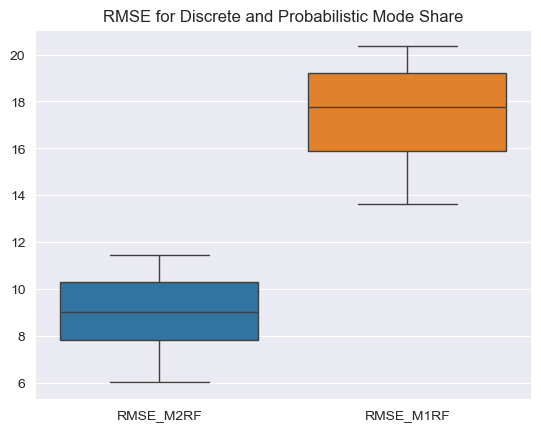

In [13]:
sns.boxplot(data=df_rms1)
plt.title('RMSE for Discrete and Probabilistic Mode Share')
plt.savefig('plots/RQ2_mode/rmse_rf_m1rf_m2rf.png')

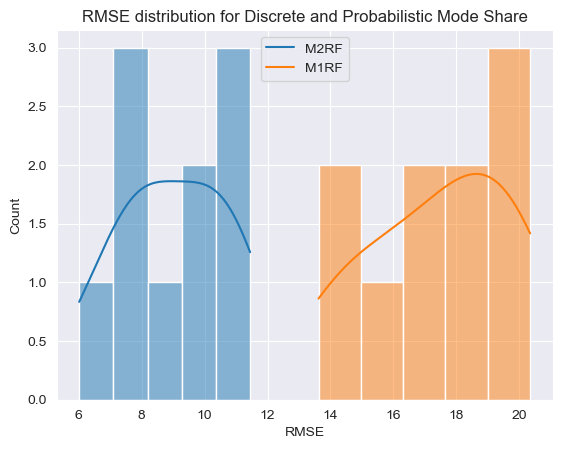

In [14]:
sns.histplot(df_rms1['RMSE_M2RF'], kde=True)
sns.histplot(df_rms1['RMSE_M1RF'], kde=True)
plt.legend(['M2RF','M1RF'])
plt.xlabel('RMSE')
plt.title('RMSE distribution for Discrete and Probabilistic Mode Share')
plt.savefig('plots/RQ2_mode/rmse_rf_m1rf_m2rf_hist.png')

In [15]:
p_values = wilcoxon(df_rms1['RMSE_M2RF'], df_rms1['RMSE_M1RF'],alternative='less')
p_values

WilcoxonResult(statistic=0.0, pvalue=0.0009765625)

In [16]:
df_moco_walk_1 = df_1[df_1.index == 'Moco Walk']
df_moco_walk_1 = df_moco_walk_1.copy() 
df_moco_walk_1

,Discrete Mode Share,Fold,Actual Mode Share,Pro. Mode Share,SE_Discrete Mode Share,SE_Pro. Mode Share
Moco Walk,18,1,30,30.977,144,0.954529
Moco Walk,29,2,41,45.469,144,19.971961
Moco Walk,21,3,37,38.627,256,2.647129
Moco Walk,29,4,47,42.085,324,24.157225
Moco Walk,30,5,33,43.061,9,101.223721
Moco Walk,29,6,37,41.214,64,17.757796
Moco Walk,28,7,44,41.180,256,7.952400
Moco Walk,31,8,37,38.194,36,1.425636
Moco Walk,24,9,32,36.344,64,18.870336
Moco Walk,21,10,44,33.981,529,100.380361


In [17]:
df_moco_walk_1.loc[:,'E_Discrete Mode Share'] = (df_moco_walk_1['Discrete Mode Share'] - df_moco_walk_1['Actual Mode Share'])
df_moco_walk_1.loc[:,'E_Pro. Mode Share'] = (df_moco_walk_1['Pro. Mode Share'] - df_moco_walk_1['Actual Mode Share'])
df_moco_walk_1 = df_moco_walk_1[['E_Discrete Mode Share','E_Pro. Mode Share']]
df_moco_walk_1.columns = ['M1RF','M2RF']
df_moco_walk_1.describe()


,M1RF,M2RF
count,10.000000,10.000000
mean,-12.200000,0.913200
std,6.124632,5.647042
min,-23.000000,-10.019000
25%,-16.000000,-1.870750
50%,-12.000000,1.410500
75%,-8.000000,4.311500
max,-3.000000,10.061000


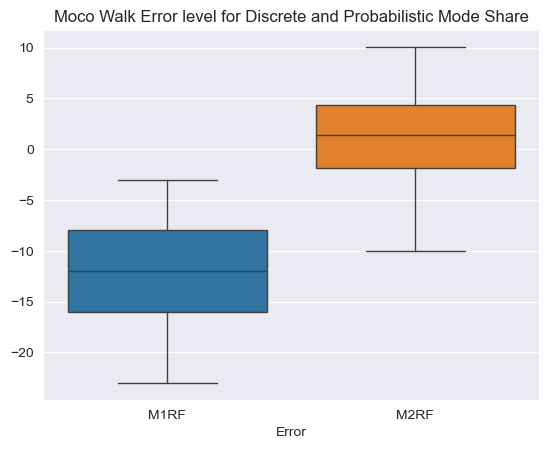

In [18]:
sns.boxplot(data=df_moco_walk_1)
plt.xlabel('Error')
plt.title('Moco Walk Error level for Discrete and Probabilistic Mode Share')
plt.savefig('plots/RQ2_mode/error_rf_m1rf_m2rf_moco_walk.png')

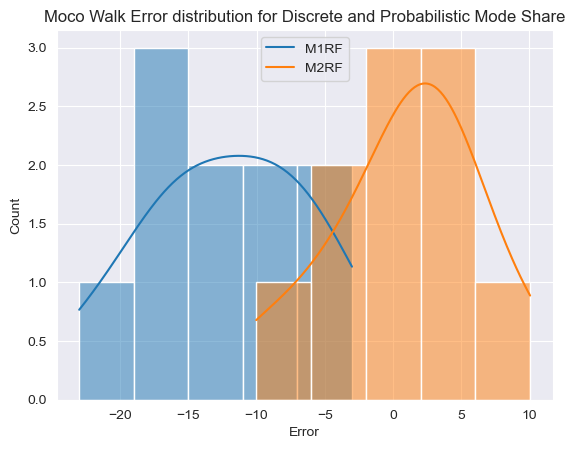

In [19]:
sns.histplot(df_moco_walk_1['M1RF'], kde=True)
sns.histplot(df_moco_walk_1['M2RF'], kde=True)
plt.legend(['M1RF','M2RF'])
plt.xlabel('Error')
plt.title('Moco Walk Error distribution for Discrete and Probabilistic Mode Share')
plt.savefig('plots/RQ2_mode/error_rf_m1rf_m2rf_moco_walk_hist.png')

In [20]:
p_values = wilcoxon(df_moco_walk_1['M2RF'], df_moco_walk_1['M1RF'],alternative='greater')
p_values

WilcoxonResult(statistic=55.0, pvalue=0.0009765625)

In [21]:
def mode_share_rf_(df_params,models):
    
    modes = ['No Moco\nPt','No Moco\nAuto','No Moco\nBike','No Moco\nWalk','Moco Pt','Moco Auto','Moco Bike','Moco Walk']
   
    df = pd.DataFrame()
    df_prob = pd.DataFrame(columns=['Pro. Mode Share'])
    for model in models:
        df_mrf = df_params[df_params['Model'] == model]
        max_depth = df_mrf['max_depth'].values[0]
        if str(max_depth) == 'nan':
            max_depth = None
        else:
            max_depth = int(max_depth)
        
        rf = RandomForestClassifier(n_estimators=df_mrf['n_estimators'].values[0], max_depth=max_depth,
                                    min_samples_split=df_mrf['min_samples_split'].values[0], 
                                    min_samples_leaf=df_mrf['min_samples_leaf'].values[0], 
                                    criterion=df_mrf['criterion'].values[0], 
                                    bootstrap=df_mrf['bootstrap'].values[0], 
                                    random_state=42)

        gf_1 = GroupKFold(n_splits=10)
        for row, (train_val_index, test_index) in enumerate(gf_1.split(X, groups=moco_survey['ResponseId'])):
            X_train_val, X_test = X.iloc[train_val_index], X.iloc[test_index]
            y_train_val, y_test = y.iloc[train_val_index], y.iloc[test_index]
                
            group_fold_2 = GroupKFold(n_splits=9)
            for train_index, val_index in group_fold_2.split(X_train_val, groups=moco_survey['ResponseId'].iloc[train_val_index]):
                X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
                y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]  
                
                rf.fit(X_train, y_train)
                
                if model == 'M5RF':
                    y_pred = rf.predict(X_test)
                    df_mode_pred = pd.DataFrame(y_pred, columns=['choice'])
                    df_mode_pred['choice'] = df_mode_pred['choice'].map({0: 'No Moco\nPt', 1: 'No Moco\nAuto', 2: 'No Moco\nBike', 3: 'No Moco\nWalk', 4: 'Moco Pt', 5: 'Moco Auto', 6: 'Moco Bike', 7: 'Moco Walk'})
                    
                    df_val_counts = df_mode_pred['choice'].value_counts().to_frame()
                    df_val_counts = df_val_counts.reindex(modes)
                    df_val_counts.rename(columns={'count': 'Discrete Mode Share'}, inplace=True)
                    df_val_counts['Fold'] = row + 1
                    
                    y_test_counts = y_test.map({0: 'No Moco\nPt', 1: 'No Moco\nAuto', 2: 'No Moco\nBike', 3: 'No Moco\nWalk', 4: 'Moco Pt', 5: 'Moco Auto', 6: 'Moco Bike', 7: 'Moco Walk'}).value_counts().to_frame()
                    y_test_counts.rename(columns={'count': 'Actual Mode Share'}, inplace=True)
                    
                    df_val_counts['Actual Mode Share'] = y_test_counts['Actual Mode Share']
                    df = pd.concat([df, df_val_counts], axis=0)
                    break
                    
                else:
                    y_pred = rf.predict_proba(X_test)
                    df_mode_pred = pd.DataFrame(y_pred, columns=['No Moco\nPt','No Moco\nAuto','No Moco\nBike','No Moco\nWalk','Moco Pt','Moco Auto','Moco Bike','Moco Walk'])
                    
                    df_mode_pred.loc['total'] = df_mode_pred.sum()
                    df_mode_pred = df_mode_pred.loc['total'].values
                    
                    df_mode_pred = pd.DataFrame(df_mode_pred, columns=['Pro. Mode Share'])
                    df_mode_pred.index = modes
                    
                    df_prob = pd.concat([df_prob, df_mode_pred], axis=0)
                    break

    df = pd.concat([df, df_prob], axis=1)
    return df        
    
    
    

In [22]:
df_2 = mode_share_rf_(df_rf_params, ['M5RF', 'M6RF'])
df_2.fillna(0, inplace=True)
df_2

df_prob columns: Index(['Pro. Mode Share'], dtype='object')
len_df: 80
len_df_prob: 80


,Discrete Mode Share,Fold,Actual Mode Share,Pro. Mode Share
No Moco\nPt,227.0,1,232,260.197437
No Moco\nAuto,273.0,1,257,221.124137
No Moco\nBike,305.0,1,279,294.478848
No Moco\nWalk,5.0,1,42,34.194598
Moco Pt,265.0,1,247,270.167694
...,...,...,...,...
No Moco\nWalk,0.0,10,35,40.702473
Moco Pt,236.0,10,254,256.245201
Moco Auto,89.0,10,164,131.060004
Moco Bike,479.0,10,345,381.302727


In [23]:
df_2['SE_Discrete Mode Share'] = (df_2['Discrete Mode Share'] - df_2['Actual Mode Share'])**2
df_2['SE_Pro. Mode Share'] = (df_2['Pro. Mode Share'] - df_2['Actual Mode Share'])**2

df_rms2 = df_2.groupby('Fold')[['SE_Pro. Mode Share','SE_Discrete Mode Share']].mean()
df_rms2 = df_rms2**0.5
cols = ['RMSE_M6RF','RMSE_M5RF']
df_rms2.columns = cols
df_rms2.describe()

,RMSE_M6RF,RMSE_M5RF
count,10.000000,10.000000
mean,20.963384,48.506470
std,6.518964,9.879688
min,8.142482,30.740852
25%,18.456331,42.442500
50%,22.871583,48.549026
75%,24.567853,54.843400
max,28.548570,62.453983


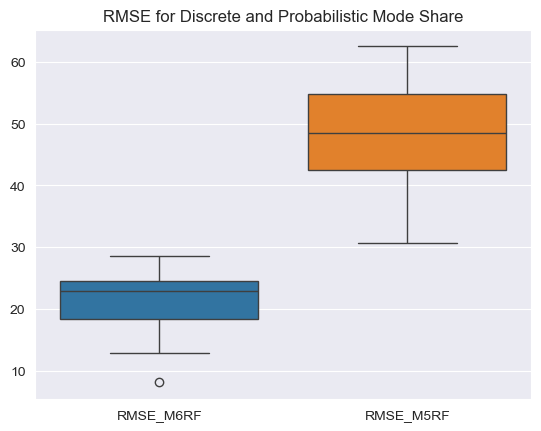

In [24]:
sns.boxplot(data=df_rms2)
plt.title('RMSE for Discrete and Probabilistic Mode Share')
plt.savefig('plots/RQ2_mode/rmse_rf_m5rf_m6rf.png')


In [25]:
p_values = wilcoxon(df_rms2['RMSE_M6RF'], df_rms2['RMSE_M5RF'],alternative='less')
p_values

WilcoxonResult(statistic=0.0, pvalue=0.0009765625)

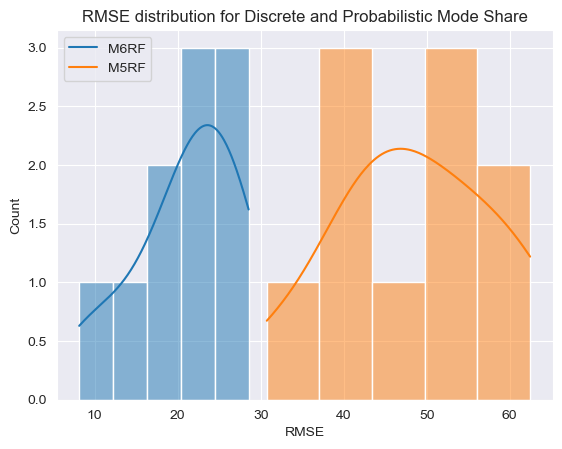

In [26]:
sns.histplot(df_rms2['RMSE_M6RF'], kde=True)
sns.histplot(df_rms2['RMSE_M5RF'], kde=True)
plt.legend(['M6RF','M5RF'])
plt.xlabel('RMSE')
plt.title('RMSE distribution for Discrete and Probabilistic Mode Share')
plt.savefig('plots/RQ2_mode/rmse_rf_m5rf_m6rf_hist.png')

In [27]:
df_moco_walk_2 = df_2[df_2.index == 'Moco Walk']
df_moco_walk_2 = df_moco_walk_2.copy()

df_moco_walk_2.loc[:,'E_Discrete Mode Share'] = (df_moco_walk_2['Discrete Mode Share'] - df_moco_walk_2['Actual Mode Share'])
df_moco_walk_2.loc[:,'E_Pro. Mode Share'] = (df_moco_walk_2['Pro. Mode Share'] - df_moco_walk_2['Actual Mode Share'])
df_moco_walk_2 = df_moco_walk_2[['E_Discrete Mode Share','E_Pro. Mode Share']]
df_moco_walk_2.columns = ['M5RF','M6RF']
df_moco_walk_2.describe()

,M5RF,M6RF
count,10.000000,10.000000
mean,-37.500000,-1.650585
std,7.199537,8.033350
min,-47.000000,-17.058840
25%,-42.500000,-4.891459
50%,-39.000000,-0.006598
75%,-31.000000,4.328445
max,-26.000000,7.391509


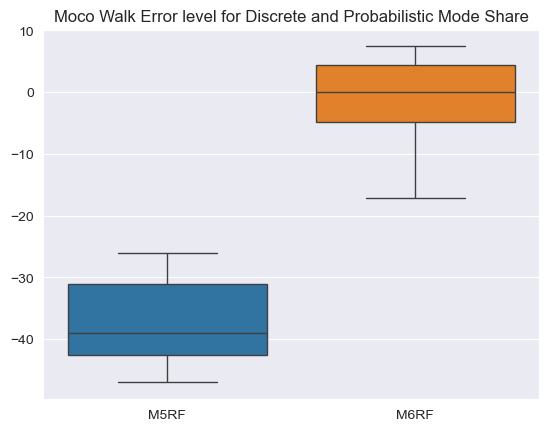

In [28]:
sns.boxplot(data=df_moco_walk_2)
plt.title('Moco Walk Error level for Discrete and Probabilistic Mode Share')
plt.savefig('plots/RQ2_mode/error_rf_m5rf_m6rf_moco_walk.png')

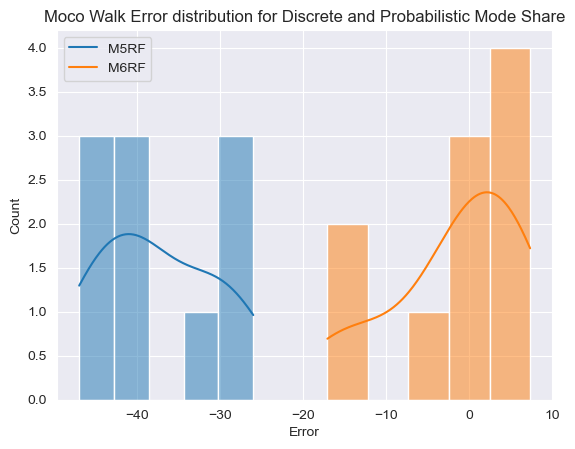

In [29]:
sns.histplot(df_moco_walk_2['M5RF'], kde=True)
sns.histplot(df_moco_walk_2['M6RF'], kde=True)
plt.legend(['M5RF','M6RF'])
plt.xlabel('Error')
plt.title('Moco Walk Error distribution for Discrete and Probabilistic Mode Share')
plt.savefig('plots/RQ2_mode/error_rf_m5rf_m6rf_moco_walk_hist.png')

In [30]:
p_values = wilcoxon(df_moco_walk_2['M6RF'], df_moco_walk_2['M5RF'],alternative='greater')
p_values

WilcoxonResult(statistic=55.0, pvalue=0.0009765625)

In [31]:
df_ann_params = pd.read_csv('reports/5_20.0/best_params_ann_5.0_20.0.csv')
df_ann_params.rename(columns={'Unnamed: 0': 'Model'}, inplace=True)
df_ann_params

,Model,n_hidden_layers,n_neurons,learning_rate,batch_size,n_epochs,dropout
0,M1ANN,2,128,0.010,500,25,0.30
1,M2ANN,2,128,0.010,500,25,0.30
2,M3ANN,2,256,0.001,500,45,0.00
3,M4ANN,3,32,0.001,128,60,0.15
4,M5ANN,1,256,0.010,128,60,0.30
5,M6ANN,1,64,0.001,1000,100,0.50
6,M7ANN,3,256,0.010,500,60,0.00
7,M8ANN,3,32,0.001,128,60,0.15
8,M9ANN,3,256,0.010,500,60,0.00
9,M10ANN,3,32,0.001,128,60,0.15


In [32]:
def mode_share_ann(data:pd.DataFrame, models: tp.List[str]):
    modes = ['No Moco\nPt','No Moco\nAuto','No Moco\nBike','No Moco\nWalk','Moco Pt','Moco Auto','Moco Bike','Moco Walk']
   
    tf.random.set_seed(42)
    np.random.seed(42)
    random.seed(42)
   
   
    df = pd.DataFrame()
    df_prob = pd.DataFrame(columns=['Pro. Mode Share'])
    for model in models:
        
        df_ann = data[data['Model'] == model]
        
        n_hidden_layers = df_ann['n_hidden_layers'].values[0]
        n_neurons = df_ann['n_neurons'].values[0]
        learning_rate = df_ann['learning_rate'].values[0]
        batch_size = df_ann['batch_size'].values[0]
        epochs = df_ann['n_epochs'].values[0]
        dropout = df_ann['dropout'].values[0]
        
        
        if model == 'M1ANN':
            kfold = KFold(n_splits=10, shuffle=True, random_state=42)
            for row, (train_val_index, test_index) in enumerate(kfold.split(X)):
                X_train_val, X_test = X.iloc[train_val_index], X.iloc[test_index]
                y_train_val, y_test = y.iloc[train_val_index], y.iloc[test_index]
                X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.11, random_state=42)
                
                scaler = StandardScaler()
                X_train = X_train.values
                X_train = scaler.fit_transform(X_train)
                X_val = X_val.values
                X_val = scaler.transform(X_val)
                X_test = X_test.values
                X_test = scaler.transform(X_test)
                ann = Sequential()
                ann.add(Dense(63, activation='relu'))
                ann.add(Dropout(dropout,seed=42))
                for _ in range(n_hidden_layers):
                    ann.add(Dense(n_neurons, activation='relu'))
                    ann.add(Dropout(dropout,seed=42))
                ann.add(Dense(8, activation='softmax'))
                
                ann.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
                ann.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0, callbacks=[EarlyStopping(patience=10,monitor ='accuracy',mode='max')],validation_data=(X_val, y_val))
                
                y_pred = np.argmax(ann.predict(X_test), axis=-1)
                
                df_mode_pred = pd.DataFrame(y_pred, columns=['choice'])
                df_mode_pred['choice'] = df_mode_pred['choice'].map({0: 'No Moco\nPt', 1: 'No Moco\nAuto', 2: 'No Moco\nBike', 3: 'No Moco\nWalk', 4: 'Moco Pt', 5: 'Moco Auto', 6: 'Moco Bike', 7: 'Moco Walk'})
                
                df_val_counts = df_mode_pred['choice'].value_counts().to_frame()
                df_val_counts = df_val_counts.reindex(modes)
                df_val_counts.rename(columns={'count': 'Discrete Mode Share'}, inplace=True)
                df_val_counts['Fold'] = row + 1
                
                y_test_counts = y_test.map({0: 'No Moco\nPt', 1: 'No Moco\nAuto', 2: 'No Moco\nBike', 3: 'No Moco\nWalk', 4: 'Moco Pt', 5: 'Moco Auto', 6: 'Moco Bike', 7: 'Moco Walk'}).value_counts().to_frame()
                y_test_counts.rename(columns={'count': 'Actual Mode Share'}, inplace=True)
                
                df_val_counts['Actual Mode Share'] = y_test_counts['Actual Mode Share']
                df = pd.concat([df, df_val_counts], axis=0)
        
        
        elif model == 'M2ANN':
            kfold = KFold(n_splits=10, shuffle=True, random_state=42)
            
            for row, (train_val_index, test_index) in enumerate(kfold.split(X)):
                X_train_val, X_test = X.iloc[train_val_index], X.iloc[test_index]
                y_train_val, y_test = y.iloc[train_val_index], y.iloc[test_index]
                X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.11, random_state=42)
                
                scaler = StandardScaler()
                X_train = X_train.values
                X_train = scaler.fit_transform(X_train)
                X_val = X_val.values
                X_val = scaler.transform(X_val)
                X_test = X_test.values
                X_test = scaler.transform(X_test)
                ann = Sequential()
                ann.add(Dense(63, activation='relu'))
                ann.add(Dropout(dropout,seed=42))
                for _ in range(n_hidden_layers):
                    ann.add(Dense(n_neurons, activation='relu'))
                    ann.add(Dropout(dropout,seed=42))
                ann.add(Dense(8, activation='softmax'))
                
                ann.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
                ann.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0, callbacks=[EarlyStopping(patience=10,monitor ='loss',mode='min')],validation_data=(X_val, y_val))
                
                
                y_pred = ann.predict(X_test)
                df_mode_pred = pd.DataFrame(y_pred, columns=['No Moco\nPt','No Moco\nAuto','No Moco\nBike','No Moco\nWalk','Moco Pt','Moco Auto','Moco Bike','Moco Walk'])
                
                df_mode_pred.loc['total'] = df_mode_pred.sum()
                df_mode_pred = df_mode_pred.loc['total'].values
                
                df_mode_pred = pd.DataFrame(df_mode_pred, columns=['Pro. Mode Share'])
                df_mode_pred.index = modes
                
                df_prob = pd.concat([df_prob, df_mode_pred], axis=0)           
            
    df = pd.concat([df, df_prob], axis=1)
    
    return df   
    

In [33]:
df_3 = mode_share_ann(df_ann_params, ['M1ANN', 'M2ANN'])
df_3

51/51 [==============================] - 0s 1ms/step
df_prob columns: Index(['Pro. Mode Share'], dtype='object')
len_df_prob: 80
len_df: 80


,Discrete Mode Share,Fold,Actual Mode Share,Pro. Mode Share
No Moco\nPt,280,1,261,302.892181
No Moco\nAuto,220,1,201,188.570541
No Moco\nBike,265,1,286,242.943954
No Moco\nWalk,24,1,41,54.420731
Moco Pt,284,1,266,269.365936
...,...,...,...,...
No Moco\nWalk,20,10,45,31.999449
Moco Pt,257,10,238,251.174667
Moco Auto,115,10,140,133.341919
Moco Bike,388,10,345,345.958954


In [34]:
df_3['SE_Discrete Mode Share'] = (df_3['Discrete Mode Share'] - df_3['Actual Mode Share'])**2
df_3['SE_Pro. Mode Share'] = (df_3['Pro. Mode Share'] - df_3['Actual Mode Share'])**2

df_rms3 = df_3.groupby('Fold')[['SE_Pro. Mode Share','SE_Discrete Mode Share']].mean()
df_rms3 = df_rms3**0.5
cols = ['RMSE_M2ANN','RMSE_M1ANN']
df_rms3.columns = cols
df_rms3.describe()

,RMSE_M2ANN,RMSE_M1ANN
count,10.000000,10.000000
mean,20.272810,39.613755
std,4.475436,15.171260
min,14.654810,17.564168
25%,16.066357,27.326749
50%,21.472096,41.820712
75%,22.307935,46.341055
max,27.152769,67.057811


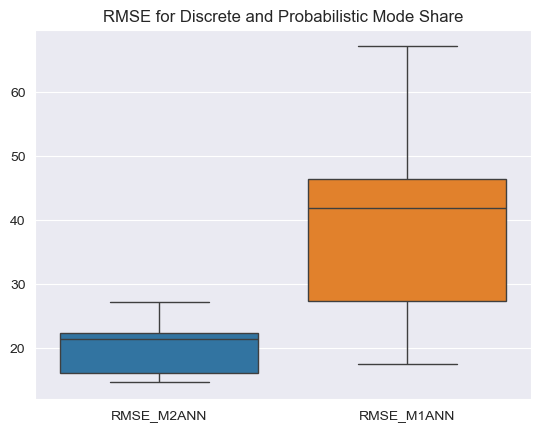

In [35]:
sns.boxplot(data=df_rms3)
plt.title('RMSE for Discrete and Probabilistic Mode Share')
plt.savefig('plots/RQ2_mode/rmse_rf_m1ann_m2ann.png')

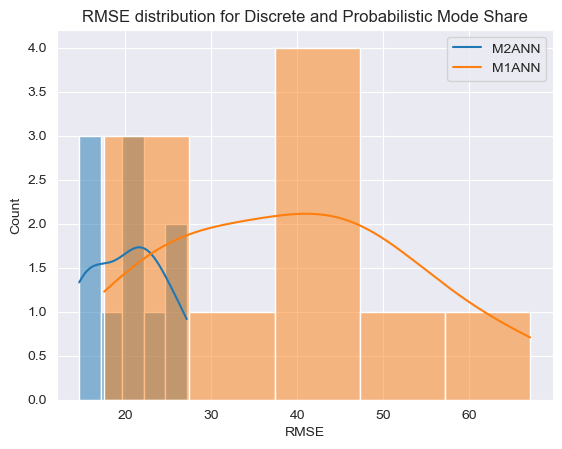

In [36]:
sns.histplot(df_rms3['RMSE_M2ANN'], kde=True)
sns.histplot(df_rms3['RMSE_M1ANN'], kde=True)
plt.legend(['M2ANN','M1ANN'])
plt.xlabel('RMSE')
plt.title('RMSE distribution for Discrete and Probabilistic Mode Share')
plt.savefig('plots/RQ2_mode/rmse_rf_m1ann_m2ann_hist.png')

In [37]:
p_values = wilcoxon(df_rms3['RMSE_M2ANN'], df_rms3['RMSE_M1ANN'],alternative='less')
p_values

WilcoxonResult(statistic=1.0, pvalue=0.001953125)

In [38]:
df_moco_walk_3 = df_3[df_3.index == 'Moco Walk']
df_moco_walk_3 = df_moco_walk_3.copy() 
df_moco_walk_3

,Discrete Mode Share,Fold,Actual Mode Share,Pro. Mode Share,SE_Discrete Mode Share,SE_Pro. Mode Share
Moco Walk,9,1,30,23.531649,441,41.839569
Moco Walk,5,2,41,18.295740,1296,515.483416
Moco Walk,20,3,37,38.254227,289,1.573085
Moco Walk,10,4,47,45.136120,1369,3.474049
Moco Walk,17,5,33,39.674480,256,44.548689
Moco Walk,7,6,37,26.272865,900,115.071419
Moco Walk,16,7,44,36.652298,784,53.988725
Moco Walk,8,8,37,46.589367,841,91.955958
Moco Walk,17,9,32,30.959391,225,1.082868
Moco Walk,7,10,44,36.759548,1369,52.424142


In [39]:
df_moco_walk_3.loc[:,'E_Discrete Mode Share'] = (df_moco_walk_3['Discrete Mode Share'] - df_moco_walk_3['Actual Mode Share'])
df_moco_walk_3.loc[:,'E_Pro. Mode Share'] = (df_moco_walk_3['Pro. Mode Share'] - df_moco_walk_3['Actual Mode Share'])
df_moco_walk_3 = df_moco_walk_3[['E_Discrete Mode Share','E_Pro. Mode Share']]
df_moco_walk_3.columns = ['M1ANN','M2ANN']
df_moco_walk_3.describe()

,M1ANN,M2ANN
count,10.000000,10.000000
mean,-26.600000,-3.987432
std,8.783824,9.204140
min,-37.000000,-22.704260
25%,-34.500000,-7.320889
50%,-28.500000,-4.166116
75%,-18.000000,0.680518
max,-15.000000,9.589367


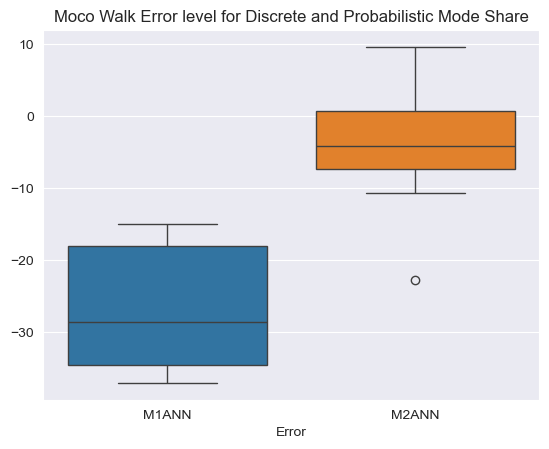

In [40]:
sns.boxplot(data=df_moco_walk_3)
plt.xlabel('Error')
plt.title('Moco Walk Error level for Discrete and Probabilistic Mode Share')
plt.savefig('plots/RQ2_mode/error_rf_m1ann_m2ann_moco_walk.png')

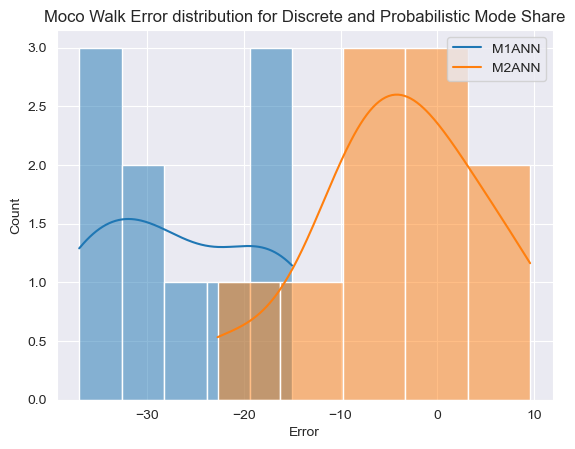

In [41]:
sns.histplot(df_moco_walk_3['M1ANN'], kde=True)
sns.histplot(df_moco_walk_3['M2ANN'], kde=True)
plt.legend(['M1ANN','M2ANN'])
plt.xlabel('Error')
plt.title('Moco Walk Error distribution for Discrete and Probabilistic Mode Share')
plt.savefig('plots/RQ2_mode/error_rf_m1ann_m2ann_moco_walk_hist.png')


In [42]:
p_values = wilcoxon(df_moco_walk_3["M2ANN"], df_moco_walk_3["M1ANN"],alternative='greater')
p_values

WilcoxonResult(statistic=55.0, pvalue=0.0009765625)

In [43]:
def mode_share_ann_(data:pd.DataFrame, models: tp.List[str]):
    modes = ['No Moco\nPt','No Moco\nAuto','No Moco\nBike','No Moco\nWalk','Moco Pt','Moco Auto','Moco Bike','Moco Walk']
   
    tf.random.set_seed(42)
    np.random.seed(42)
    random.seed(42)
   
   
    df = pd.DataFrame()
    df_prob = pd.DataFrame(columns=['Pro. Mode Share'])
    for model in models:
        
        df_ann = data[data['Model'] == model]
        
        n_hidden_layers = df_ann['n_hidden_layers'].values[0]
        n_neurons = df_ann['n_neurons'].values[0]
        learning_rate = df_ann['learning_rate'].values[0]
        batch_size = df_ann['batch_size'].values[0]
        epochs = df_ann['n_epochs'].values[0]
        dropout = df_ann['dropout'].values[0]
        
        
        if model == 'M5ANN':
            
            gf_1 = GroupKFold(n_splits=10)
            
            for row, (train_val_index, test_index) in enumerate(gf_1.split(X, groups=moco_survey['ResponseId'])):
                
                X_train_val, X_test = X.iloc[train_val_index], X.iloc[test_index]
                y_train_val, y_test = y.iloc[train_val_index], y.iloc[test_index]
                
                group_fold_2 = GroupKFold(n_splits=9)
                
                for train_index, val_index in group_fold_2.split(X_train_val, groups=moco_survey['ResponseId'].iloc[train_val_index]):
                    
                    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
                    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]
                    
                    scaler = StandardScaler()
                    X_train = X_train.values
                    X_train = scaler.fit_transform(X_train)
                    X_val = X_val.values
                    X_val = scaler.transform(X_val)
                    X_test = X_test.values
                    X_test = scaler.transform(X_test)
                    ann = Sequential()
                    ann.add(Dense(63, activation='relu'))
                    ann.add(Dropout(dropout,seed=42))
                    for _ in range(n_hidden_layers):
                        ann.add(Dense(n_neurons, activation='relu'))
                        ann.add(Dropout(dropout,seed=42))
                    ann.add(Dense(8, activation='softmax'))
                    
                    ann.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
                    ann.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0, callbacks=[EarlyStopping(patience=10,monitor ='accuracy',mode='max')],validation_data=(X_val, y_val))
                    
                    y_pred = np.argmax(ann.predict(X_test), axis=-1)
                    
                    df_mode_pred = pd.DataFrame(y_pred, columns=['choice'])
                    df_mode_pred['choice'] = df_mode_pred['choice'].map({0: 'No Moco\nPt', 1: 'No Moco\nAuto', 2: 'No Moco\nBike', 3: 'No Moco\nWalk', 4: 'Moco Pt', 5: 'Moco Auto', 6: 'Moco Bike', 7: 'Moco Walk'})
                    
                    df_val_counts = df_mode_pred['choice'].value_counts().to_frame()
                    df_val_counts = df_val_counts.reindex(modes)
                    df_val_counts.rename(columns={'count': 'Discrete Mode Share'}, inplace=True)
                    df_val_counts['Fold'] = row + 1
                    
                    y_test_counts = y_test.map({0: 'No Moco\nPt', 1: 'No Moco\nAuto', 2: 'No Moco\nBike', 3: 'No Moco\nWalk', 4: 'Moco Pt', 5: 'Moco Auto', 6: 'Moco Bike', 7: 'Moco Walk'}).value_counts().to_frame()
                    y_test_counts.rename(columns={'count': 'Actual Mode Share'}, inplace=True)
                    
                    df_val_counts['Actual Mode Share'] = y_test_counts['Actual Mode Share']
                    df = pd.concat([df, df_val_counts], axis=0)
                    
                    break
                    
        elif model == 'M6ANN':
            
            gf_1 = GroupKFold(n_splits=10)
            
            for row, (train_val_index, test_index) in enumerate(gf_1.split(X, groups=moco_survey['ResponseId'])):
                
                X_train_val, X_test = X.iloc[train_val_index], X.iloc[test_index]
                y_train_val, y_test = y.iloc[train_val_index], y.iloc[test_index]
                
                group_fold_2 = GroupKFold(n_splits=9)
                
                for train_index, val_index in group_fold_2.split(X_train_val, groups=moco_survey['ResponseId'].iloc[train_val_index]):
                    
                    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
                    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]
                    
                    scaler = StandardScaler()
                    X_train = X_train.values
                    X_train = scaler.fit_transform(X_train)
                    X_val = X_val.values
                    X_val = scaler.transform(X_val)
                    X_test = X_test.values
                    X_test = scaler.transform(X_test)
                    ann = Sequential()
                    ann.add(Dense(63, activation='relu'))
                    ann.add(Dropout(dropout,seed=42))
                    for _ in range(n_hidden_layers):
                        ann.add(Dense(n_neurons, activation='relu'))
                        ann.add(Dropout(dropout,seed=42))
                    ann.add(Dense(8, activation='softmax'))
                    
                    ann.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
                    ann.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0, callbacks=[EarlyStopping(patience=10,monitor ='loss',mode='min')],validation_data=(X_val, y_val))
                    
                    y_pred = ann.predict(X_test)
                    df_mode_pred = pd.DataFrame(y_pred, columns=['No Moco\nPt','No Moco\nAuto','No Moco\nBike','No Moco\nWalk','Moco Pt','Moco Auto','Moco Bike','Moco Walk'])
                    
                    df_mode_pred.loc['total'] = df_mode_pred.sum()
                    df_mode_pred = df_mode_pred.loc['total'].values
                    
                    df_mode_pred = pd.DataFrame(df_mode_pred, columns=['Pro. Mode Share'])
                    df_mode_pred.index = modes
                    
                    df_prob = pd.concat([df_prob, df_mode_pred], axis=0)
                    break
    
    df = pd.concat([df, df_prob], axis=1)

    return df

In [44]:
df_4 = mode_share_ann_(df_ann_params, ['M5ANN', 'M6ANN'])
df_4.fillna(0, inplace=True)
df_4

51/51 [==============================] - 0s 880us/step
df_prob columns: Index(['Pro. Mode Share'], dtype='object')
len_df_prob: 80
len_df: 80


,Discrete Mode Share,Fold,Actual Mode Share,Pro. Mode Share
No Moco\nPt,288.0,1,232,262.752930
No Moco\nAuto,242.0,1,257,213.683456
No Moco\nBike,280.0,1,279,304.709808
No Moco\nWalk,0.0,1,42,29.017761
Moco Pt,392.0,1,247,274.754730
...,...,...,...,...
No Moco\nWalk,14.0,10,35,35.470924
Moco Pt,228.0,10,254,260.860565
Moco Auto,91.0,10,164,130.408676
Moco Bike,476.0,10,345,383.686981


In [45]:
df_4['SE_Discrete Mode Share'] = (df_4['Discrete Mode Share'] - df_4['Actual Mode Share'])**2
df_4['SE_Pro. Mode Share'] = (df_4['Pro. Mode Share'] - df_4['Actual Mode Share'])**2

df_rms4 = df_4.groupby('Fold')[['SE_Pro. Mode Share','SE_Discrete Mode Share']].mean()
df_rms4 = df_rms4**0.5
cols = ['RMSE_M6ANN','RMSE_M5ANN']
df_rms4.columns = cols
df_rms4.describe()


,RMSE_M6ANN,RMSE_M5ANN
count,10.000000,10.000000
mean,25.277026,56.893720
std,8.063947,9.896951
min,8.580130,41.871828
25%,21.444405,49.969318
50%,26.530028,57.586539
75%,27.914790,61.445948
max,39.487001,72.809683


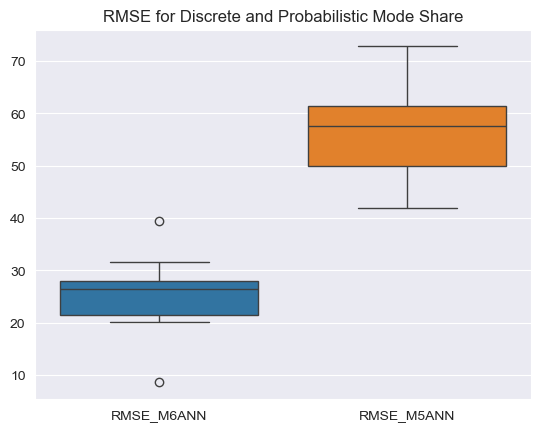

In [46]:
sns.boxplot(data=df_rms4)
plt.title('RMSE for Discrete and Probabilistic Mode Share')
plt.savefig('plots/RQ2_mode/rmse_rf_m5ann_m6ann.png')


In [47]:
p_values = wilcoxon(df_rms4['RMSE_M6ANN'], df_rms4['RMSE_M5ANN'],alternative='less')
p_values


WilcoxonResult(statistic=0.0, pvalue=0.0009765625)

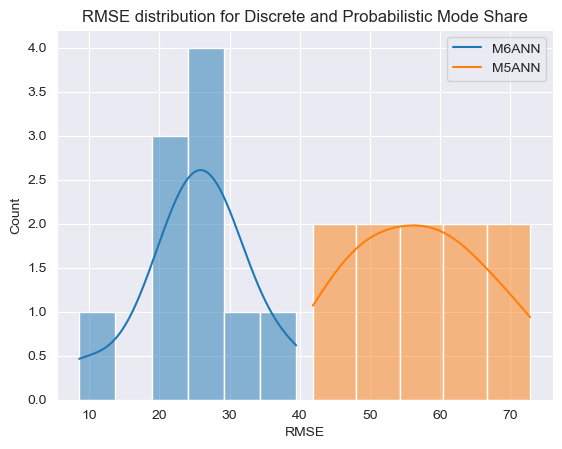

In [48]:
sns.histplot(df_rms4['RMSE_M6ANN'], kde=True)
sns.histplot(df_rms4['RMSE_M5ANN'], kde=True)
plt.legend(['M6ANN','M5ANN'])
plt.xlabel('RMSE')
plt.title('RMSE distribution for Discrete and Probabilistic Mode Share')
plt.savefig('plots/RQ2_mode/rmse_rf_m5ann_m6ann_hist.png')


In [49]:
df_moco_walk_4 = df_4[df_4.index == 'Moco Walk']
df_moco_walk_4 = df_moco_walk_4.copy()

df_moco_walk_4.loc[:,'E_Discrete Mode Share'] = (df_moco_walk_4['Discrete Mode Share'] - df_moco_walk_4['Actual Mode Share'])
df_moco_walk_4.loc[:,'E_Pro. Mode Share'] = (df_moco_walk_4['Pro. Mode Share'] - df_moco_walk_4['Actual Mode Share'])
df_moco_walk_4 = df_moco_walk_4[['E_Discrete Mode Share','E_Pro. Mode Share']]
df_moco_walk_4.columns = ['M5ANN','M6ANN']
df_moco_walk_4.describe()




,M5ANN,M6ANN
count,10.000000,10.000000
mean,-34.000000,-9.196740
std,6.377042,7.954605
min,-47.000000,-23.586599
25%,-35.250000,-11.730037
50%,-33.000000,-8.202114
75%,-31.250000,-4.744250
max,-26.000000,0.487019


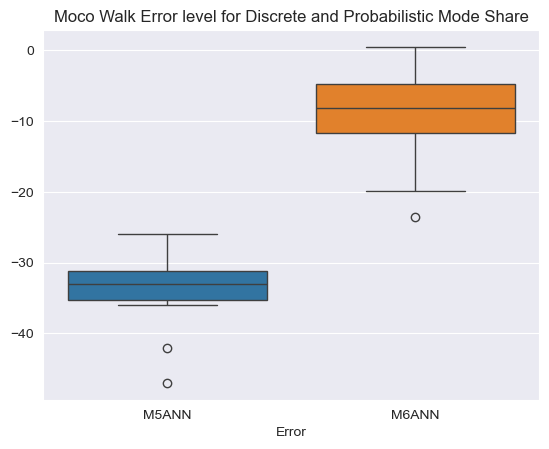

In [50]:
sns.boxplot(data=df_moco_walk_4)
plt.title('Moco Walk Error level for Discrete and Probabilistic Mode Share')
plt.xlabel('Error')

plt.savefig('plots/RQ2_mode/error_rf_m5ann_m6ann_moco_walk.png')


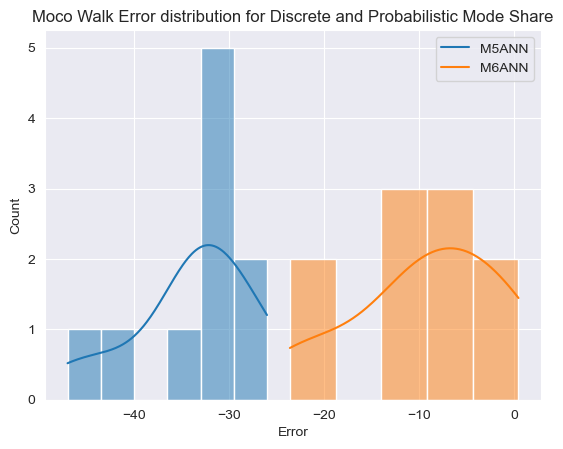

In [51]:
sns.histplot(df_moco_walk_4['M5ANN'], kde=True)
sns.histplot(df_moco_walk_4['M6ANN'], kde=True)
plt.legend(['M5ANN','M6ANN'])
plt.xlabel('Error')
plt.title('Moco Walk Error distribution for Discrete and Probabilistic Mode Share')
plt.savefig('plots/RQ2_mode/error_rf_m5ann_m6ann_moco_walk_hist.png')



In [52]:
p_values = wilcoxon(df_moco_walk_4['M6ANN'], df_moco_walk_4['M5ANN'],alternative='greater')
p_values


WilcoxonResult(statistic=55.0, pvalue=0.0009765625)

In [53]:
df_5 = pd.concat([df_rms1, df_rms3], axis=1)
df_6 = pd.concat([df_rms2, df_rms4], axis=1)
df_7 = pd.concat([df_moco_walk_1, df_moco_walk_3], axis=1)
df_8 = pd.concat([df_moco_walk_2, df_moco_walk_4], axis=1)


C:\Users\berha\AppData\Local\Temp\ipykernel_15628\3131270980.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


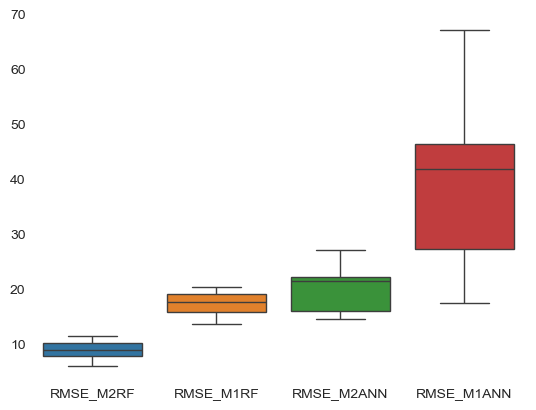

In [61]:
plt.style.use('seaborn-white')
plt.box(False)
sns.boxplot(data=df_5)
plt.savefig('plots/RQ2_mode/rmse_rf_ann_m1_m2.png')

C:\Users\berha\AppData\Local\Temp\ipykernel_15628\2197141687.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


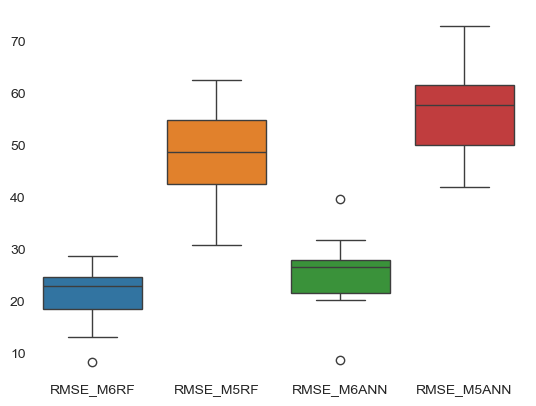

In [62]:
plt.style.use('seaborn-white')
plt.box(False)
sns.boxplot(data=df_6)
plt.savefig('plots/RQ2_mode/rmse_rf_ann_m5_m6.png')

C:\Users\berha\AppData\Local\Temp\ipykernel_15628\1368974616.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


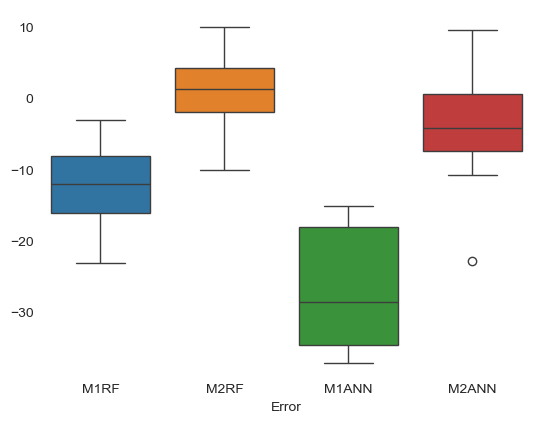

In [63]:
plt.style.use('seaborn-white')
plt.box(False)
sns.boxplot(data=df_7)
plt.xlabel('Error')
plt.savefig('plots/RQ2_mode/moco_walk_error_rf_ann_m1_m2.png')


C:\Users\berha\AppData\Local\Temp\ipykernel_15628\3780904710.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


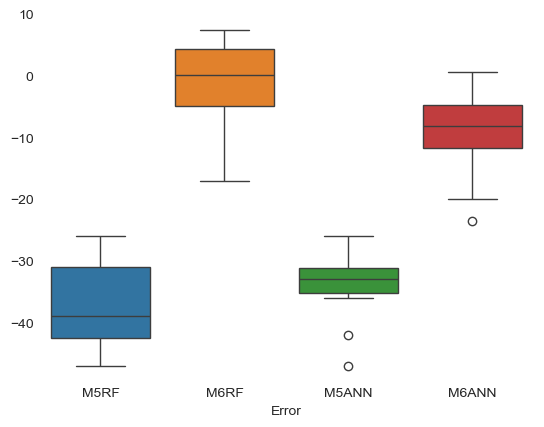

In [67]:
plt.style.use('seaborn-white')
plt.box(False)
sns.boxplot(data=df_8)
plt.xlabel('Error')
plt.savefig('plots/RQ2_mode/moco_walk_error_rf_ann_m5_m6.png')
